# Функциональный API

Мы хотим строить сложные разветвлённые модели, а не какие-то там жалкие линейные. Ещё хотим трюки разные использовать. Например, делать ResNet слои. В таких ситуациях нам на помощь приходит функциональный API от keras. Он позволяет придумывать и реализовывать сетки как угодно.

## 1. Введение в функциональный API

In [1]:
import tensorflow.keras as  keras
import tensorflow as tf
from tensorflow.keras import Input, layers 

input_tensor = Input(shape=(32,))
dense = layers.Dense(32, activation='relu')
output_tensor = dense(input_tensor)

Начнем с маленького примера, который описывает как обычную модель можно представить с помощью функционального API. На самом деле мы с вами уже видели его раньше. Зададим небольшую сетку с помощью класса `Sequential`. Она линейная. Каждый выход это вход для следующего. 

In [2]:
from tensorflow.keras.models import Sequential, Model 

seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,))) 
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))

А теперь возьмём её и перепишем в функциональном стиле. Каждый слой это функция, которую мы применяем к какому-то входу. 

In [3]:
input_tensor = Input(shape=(64,))

x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = Model(input_tensor, output_tensor)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


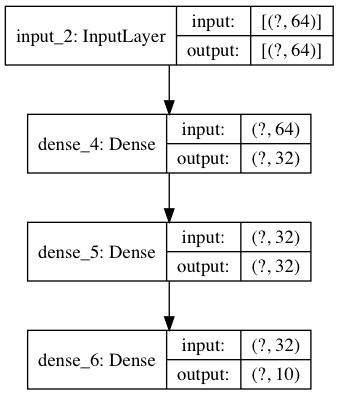

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

# можно нарисовать картинку 
# SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

Единственная часть, которая может показаться немного волшебной - создание экземпляра объекта `Model` с использованием только входного и выходного тензоров. За кулисами Keras извлекает все слои, участвующие в переходе от `input_tensor` к `output_tensor`, объединяя их в граф вычислений. Тут важно заметить, что `output_tensor` и `input_tensor` связаны межу собой вычислениями. Если попытаться построить модель из входных и выходных данных, которые не были связаны выскочит ошибка. 

In [5]:
unrelated_input = Input(shape=(32,))
bad_model = Model(unrelated_input, output_tensor)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_2:0", shape=(None, 64), dtype=float32) at layer "input_2". The following previous layers were accessed without issue: []

Ошибка говорит нам о том, что керас не смог достичь `output`, преобразовывая `input`. Всё остальное работает точно также, как и раньше.

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

import numpy as np
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10)) 

model.fit(x_train, y_train, epochs=10, batch_size=128)

score = model.evaluate(x_train, y_train, verbose=0)
score

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 0s 472us/sample - loss: 89.9005
Epoch 2/10
1000/1000 [==============================] - 0s 13us/sample - loss: 97.5544
Epoch 3/10
1000/1000 [==============================] - 0s 14us/sample - loss: 104.5385
Epoch 4/10
1000/1000 [==============================] - 0s 17us/sample - loss: 111.6261
Epoch 5/10
1000/1000 [==============================] - 0s 16us/sample - loss: 118.7504
Epoch 6/10
1000/1000 [==============================] - 0s 15us/sample - loss: 125.8749
Epoch 7/10
1000/1000 [==============================] - 0s 14us/sample - loss: 131.8483
Epoch 8/10
1000/1000 [==============================] - 0s 15us/sample - loss: 138.3323
Epoch 9/10
1000/1000 [==============================] - 0s 14us/sample - loss: 144.4814
Epoch 10/10
1000/1000 [==============================] - 0s 18us/sample - loss: 151.5077


155.15062744140624


## 2. Модели с несколькими входами

Функциональный API может использоваться для построения моделей с несколькими входами. Как правило, такие модели в какой-то момент объединяют свои ветви, используя слой, который может объединять несколько тензоров. (`keras.layers.add`, `keras.layers.concatenate` и тп)

### Диалоговая система

Представим себе, что мы пытаемся построить сетку, которая умеет отвечать на вопросы. Чтобы выйчить её, надо показать ей кучу примеров вопросов и ответов на них. У сетки будет два входа. На выходе мы будем получать вероятность того, что ответ релевантен вопросу. 

In [9]:
from tensorflow.keras import Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# Ввод текста представляет собой последовательность целых чисел переменной длины.
# Обратите внимание, что вы можете по желанию назвать входы
text_input = Input(shape=(None,), dtype='int32', name='text')
embedded_text = layers.Embedding(text_vocabulary_size,64)(text_input)

# С помощью LSTM переводим текст в последовательность
encoded_text = layers.LSTM(32)(embedded_text)

# Тот же процесс (с разными экземплярами слоя) для вопроса
question_input = Input(shape=(None,),dtype='int32',name='question')
embedded_question = layers.Embedding(question_vocabulary_size,32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question) 

# Соеденяем вопрос и текст
concatenated = layers.concatenate([encoded_text, encoded_question],
                                  axis=-1)
# Добавляем softmax итоговый
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)

# Модельс 2-мя входами и 1 выходом, поэтому задаем таким образом
model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['acc'])

In [10]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
question (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     320000      question[0][0]                   
____________________________________________________________________________________________

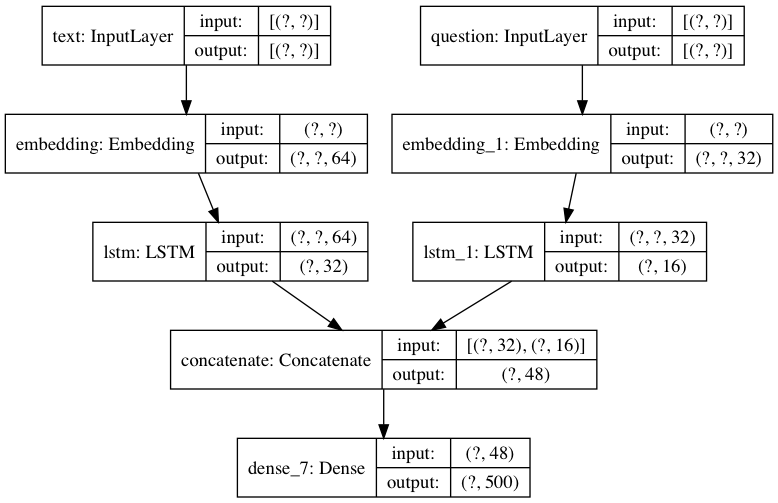

In [11]:
plot_model(model, show_shapes = True)

### Обучение модели с несколькими входами

In [13]:
import numpy as np
num_samples = 1000 
max_length = 100

# модельные данные
text = np.random.randint(1, text_vocabulary_size,size=(num_samples, max_length))
text

array([[8249, 7934, 2402, ..., 5635, 5652, 8795],
       [7926, 2893, 4462, ..., 9217, 6354, 2913],
       [ 130, 7217, 2107, ..., 5331, 8132, 7300],
       ...,
       [3175,  426, 7300, ..., 4267, 7387, 6286],
       [2506, 5091, 5337, ..., 1935, 7623, 1521],
       [ 777,  576, 3748, ..., 2306, 8417, 1693]])

In [14]:
question = np.random.randint(1, question_vocabulary_size,size=(num_samples, max_length))
question

array([[7922, 4275, 5083, ...,  803, 8987, 6636],
       [3746, 7599, 7888, ..., 2446, 7148, 4821],
       [7082, 6660, 6626, ...,  812, 8820, 9383],
       ...,
       [8113, 6638, 1301, ..., 8740, 7317, 6778],
       [4680, 5848, 8101, ..., 7611, 6410, 7998],
       [   6, 7778, 4041, ..., 8418, 6331, 2274]])

In [15]:
# выход из сетки это релевантность ответа вопросу
answers = np.random.randint(answer_vocabulary_size, size=(num_samples))
answers = keras.utils.to_categorical(answers, answer_vocabulary_size)
answers

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Подать данные на вход можно двумя способами. Либо как лист:

In [16]:
model.fit([text, question], answers, epochs=10, batch_size=128)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 6.2144 - acc: 0.0030
Epoch 2/10
1000/1000 [==============================] - 1s 663us/sample - loss: 6.1957 - acc: 0.0380
Epoch 3/10
1000/1000 [==============================] - 1s 686us/sample - loss: 6.1296 - acc: 0.0150
Epoch 4/10
1000/1000 [==============================] - 1s 676us/sample - loss: 6.0385 - acc: 0.0040
Epoch 5/10
1000/1000 [==============================] - 1s 650us/sample - loss: 5.9886 - acc: 0.0080
Epoch 6/10
1000/1000 [==============================] - 1s 660us/sample - loss: 5.9116 - acc: 0.0080
Epoch 7/10
1000/1000 [==============================] - 1s 639us/sample - loss: 5.8110 - acc: 0.0120
Epoch 8/10
1000/1000 [==============================] - 1s 654us/sample - loss: 5.7221 - acc: 0.0230
Epoch 9/10
1000/1000 [==============================] - 1s 652us/sample - loss: 5.6491 - acc: 0.0250
Epoch 10/10
1000/1000 [==============================] - 1s 649us/sampl

Либо как словарь:

In [17]:
model.fit({'text': text, 'question': question}, answers,epochs=10, batch_size=128)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 1s 652us/sample - loss: 5.5245 - acc: 0.0360
Epoch 2/10
1000/1000 [==============================] - 1s 688us/sample - loss: 5.4556 - acc: 0.0430
Epoch 3/10
1000/1000 [==============================] - 1s 726us/sample - loss: 5.3983 - acc: 0.0380
Epoch 4/10
1000/1000 [==============================] - 1s 651us/sample - loss: 5.3339 - acc: 0.0430
Epoch 5/10
1000/1000 [==============================] - 1s 724us/sample - loss: 5.2797 - acc: 0.0440
Epoch 6/10
1000/1000 [==============================] - 1s 807us/sample - loss: 5.2286 - acc: 0.0480
Epoch 7/10
1000/1000 [==============================] - 1s 710us/sample - loss: 5.1893 - acc: 0.0590
Epoch 8/10
1000/1000 [==============================] - 1s 719us/sample - loss: 5.1238 - acc: 0.0500
Epoch 9/10
1000/1000 [==============================] - 1s 650us/sample - loss: 5.0703 - acc: 0.0640
Epoch 10/10
1000/1000 [==============================] - 1s 662us/sam

## 3. Модели с несколькими выходами

Можно собирать модели с несколькими выходами! 

### Пример - прогноз возраста, пола и дохода от постов в социальных сетях

Сеть пытается предсказать по сообщению человека в социальных сетках его возраст, пол и доход. 

In [19]:
vocabulary_size = 50000 
num_income_groups = 10 

In [20]:
import numpy as np 

num_samples = 1000 
max_length = 100

posts = np.random.randint(1, vocabulary_size, size=(num_samples, max_length))
posts

array([[18086, 31431, 18383, ..., 33880, 20252, 41523],
       [39307,  2062, 24098, ...,  3734, 20822, 36207],
       [23552,  8984, 15497, ..., 15005, 13226, 13150],
       ...,
       [41540,  4115, 41274, ..., 31307, 15051, 16916],
       [ 7925, 25211, 40598, ..., 31897, 43335, 13919],
       [10057,  8892, 33924, ...,  6230, 18346,  8136]])

In [23]:
age_targets = np.random.randint(0, 100, size=(num_samples,1))
age_targets[:10]

array([[68],
       [63],
       [51],
       [26],
       [91],
       [22],
       [66],
       [57],
       [23],
       [40]])

In [24]:
income_targets = np.random.randint(1, num_income_groups, size=(num_samples,1))
income_targets = keras.utils.to_categorical(income_targets,num_income_groups)
income_targets[:10]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [25]:
gender_targets = np.random.randint(0, 2, size=(num_samples,1))
gender_targets[:10]

array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1]])

Собираем модель.

In [27]:
posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocabulary_size,256)(posts_input)

x = layers.Conv1D(128, 5, activation='relu', padding='same')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x) 
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x) 

# Заметим, что выходным лаерам лучше дать имя.
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups,
                                 activation='softmax',name='income')(x)

gender_prediction = layers.Dense(1, activation='sigmoid',
                                 name='gender')(x)

model = Model(posts_input,[age_prediction, income_prediction, 
                           gender_prediction])

Лоя разных выходов надо задавать разные функции потерь. Например, прогнозирование возраста регрессия, пола классификация. Все эти потери надо будет объединить в один функционал. Каждой придать свой вес. Сложно, короче говоря. 

In [28]:
# снова либо списком либо словарем, словарь работает если мы дали тензорам имена
model.compile(optimizer='rmsprop', loss=['mse', 
                                         'categorical_crossentropy',
                                         'binary_crossentropy'])

model.compile(optimizer='rmsprop',loss={'age': 'mse',
                                        'income': 'categorical_crossentropy',
                                        'gender': 'binary_crossentropy'})

Посмотрим как можно на разные функции потерь накидывать веса. Из-за того, что они могут быть несбалансированны, один выход может задоминировать другой. 

In [29]:
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[0.25, 1., 10.]) 

model.compile(optimizer='rmsprop',
              
              loss={'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy'},
              
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

In [30]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, None, 128)    163968      embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, None, 128)    0           conv1d_5[0][0]                   
____________________________________________________________________________________________

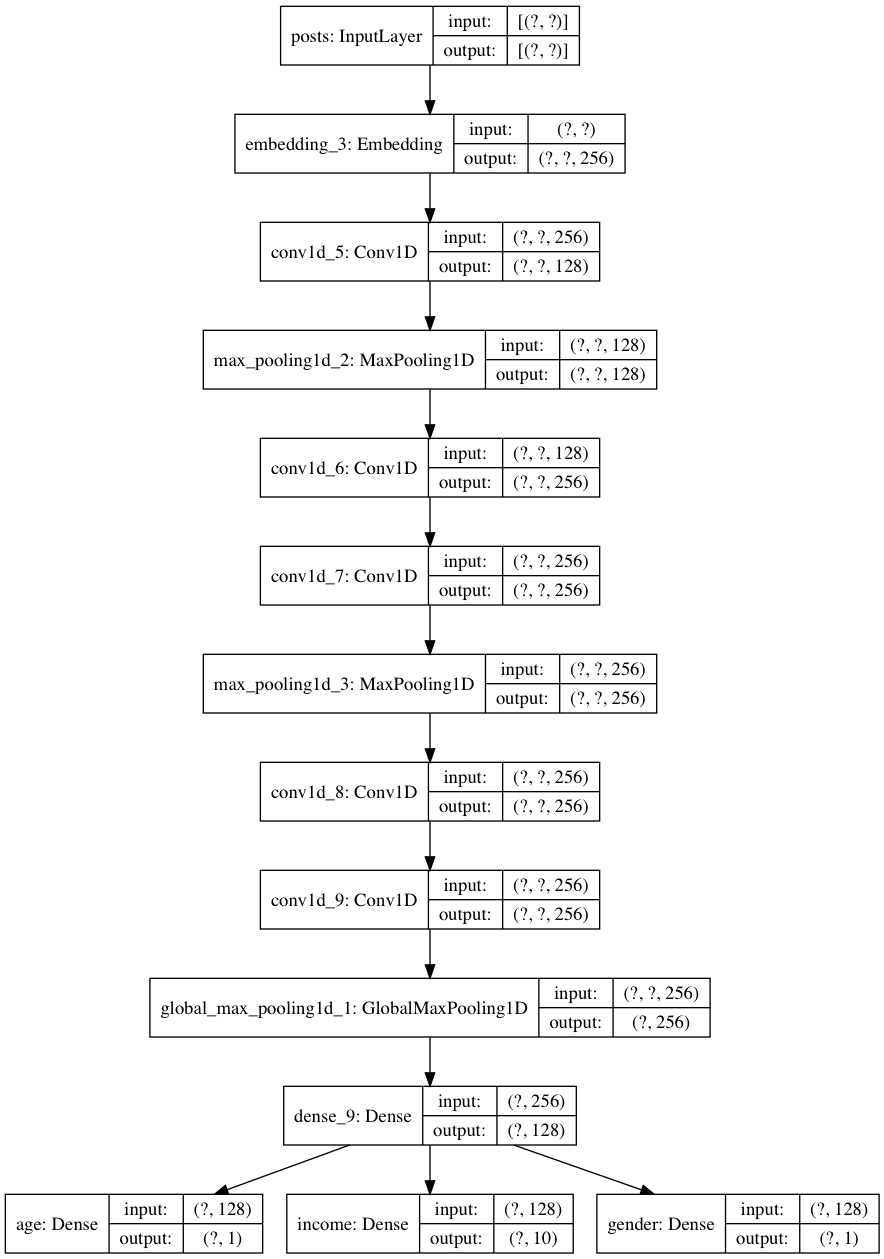

In [31]:
plot_model(model, show_shapes = True)

Подавать данные на вход снова можно двумя способами.

In [32]:
model.fit(posts, [age_targets, income_targets, gender_targets], epochs=10, batch_size=64)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 6s 6ms/sample - loss: 452.1246 - age_loss: 1716.1199 - income_loss: 3.6811 - gender_loss: 1.3901
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 217.5826 - age_loss: 811.8288 - income_loss: 2.4047 - gender_loss: 1.0989
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 157.0592 - age_loss: 575.8844 - income_loss: 2.3845 - gender_loss: 0.9254
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 120.7433 - age_loss: 438.1556 - income_loss: 2.3421 - gender_loss: 0.8683
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 98.8332 - age_loss: 353.0813 - income_loss: 2.3322 - gender_loss: 0.9181
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/sample - loss: 100.8909 - age_loss: 356.2400 - income_loss: 2.3712 - gender_loss: 0.9536
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/sam

In [33]:
model.fit(posts, {'age': age_targets,
                  'income': income_targets,
                  'gender': gender_targets},
         epochs=10, 
         batch_size=64)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 73.3959 - age_loss: 236.3918 - income_loss: 2.3427 - gender_loss: 1.1028
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 76.1376 - age_loss: 257.3674 - income_loss: 2.2820 - gender_loss: 0.8575
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 57.6873 - age_loss: 179.1359 - income_loss: 2.3472 - gender_loss: 0.9715
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 69.5472 - age_loss: 235.1942 - income_loss: 2.3167 - gender_loss: 0.8424
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 67.9493 - age_loss: 220.1999 - income_loss: 2.3503 - gender_loss: 1.0044
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 57.6815 - age_loss: 177.3044 - income_loss: 2.3120 - gender_loss: 1.1436
Epoch 7/10
1000/1000 [==============================] - 4s 4ms/sample - 

## 4 Направленные ациклические графы

Можно собирать сетки со сложной внутренней топологией. Карась разрешает ориентровать слои как угодно. Главнео, чтобы не было циклов. 

### 4.1 Inception модули

Ну чтож ваша очередь объяснять, что тут в коде происходит :) не только же мне мучаться:)

In [34]:
# Пример реализован для MNIST 

x = Input(shape=(28, 28, 1), dtype='float32', name='images')

print("x.shape:",x.shape)


branch_a = layers.Conv2D(128, 1, padding='same',
                         activation='relu', strides=2)(x)


branch_b = layers.Conv2D(128, 1, padding='same', 
                         activation='relu')(x)
branch_b = layers.Conv2D(128, 3, padding='same',
                         activation='relu', strides=2)(branch_b)


branch_c = layers.AveragePooling2D(3,  padding='same', strides=2)(x)
branch_c = layers.Conv2D(128, 3, 
                         padding='same',
                         activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(x) 
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)


output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], 
                            axis=-1)

output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)

model_intersept = keras.models.Model(inputs=x, outputs=predictions)
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

x.shape: (None, 28, 28, 1)


In [35]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, None, 128)    163968      embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, None, 128)    0           conv1d_5[0][0]                   
____________________________________________________________________________________________

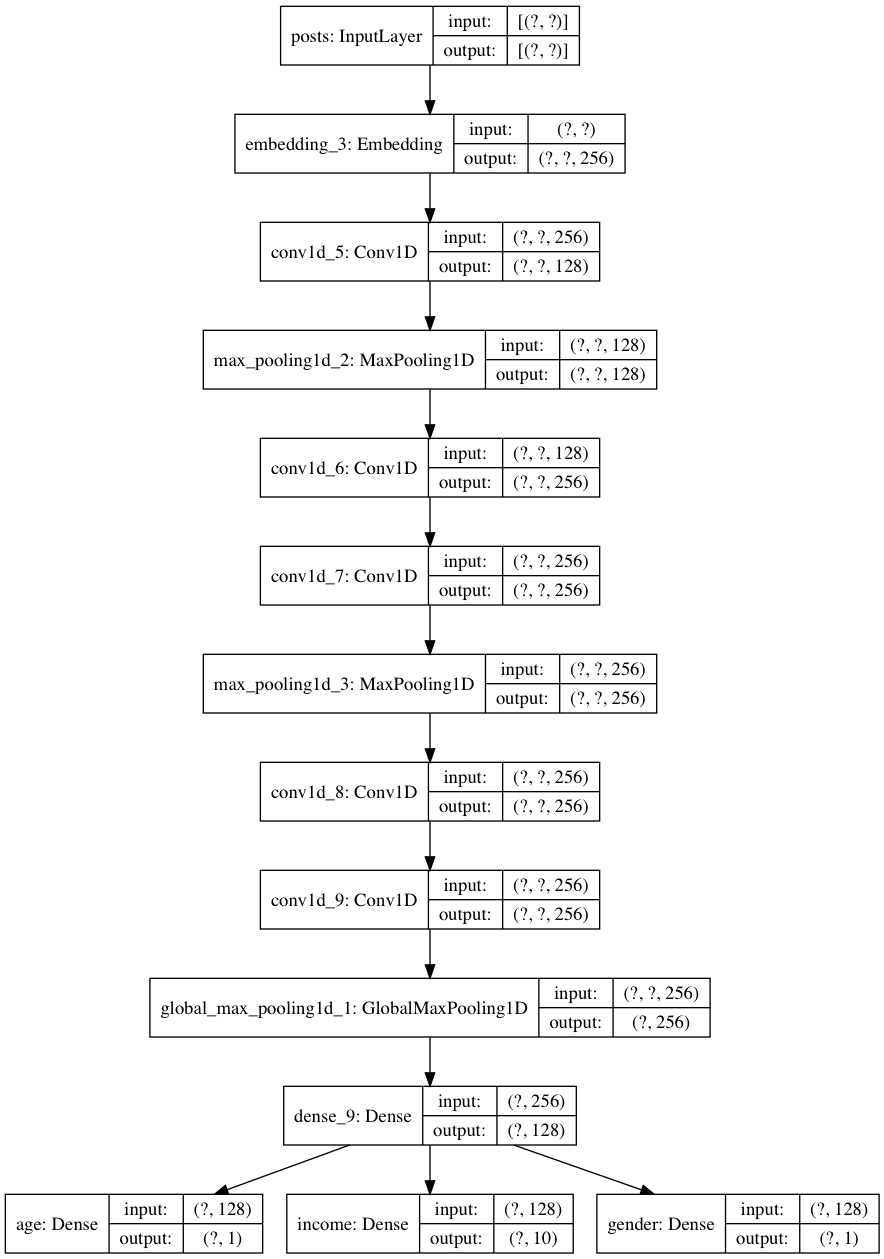

In [36]:
plot_model(model, show_shapes = True)

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              target_tensors=[targets])

### 4.2  ResNET

Теперь очередь Resnet-модуля :) 

In [41]:
from keras import layers 
from keras.layers import Input

x = Input(shape=(28, 28, 1), dtype='float32', name='images')

# Применяем преобразования
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

# Добавляем х вконец
output = layers.add([y, x])

# Добавляем сверху классификатор
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)

model = Model(x, predictions )

x.shape: (None, 28, 28, 1)


AttributeError: 'tuple' object has no attribute 'layer'

In [39]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, None, 128)    163968      embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, None, 128)    0           conv1d_5[0][0]                   
____________________________________________________________________________________________

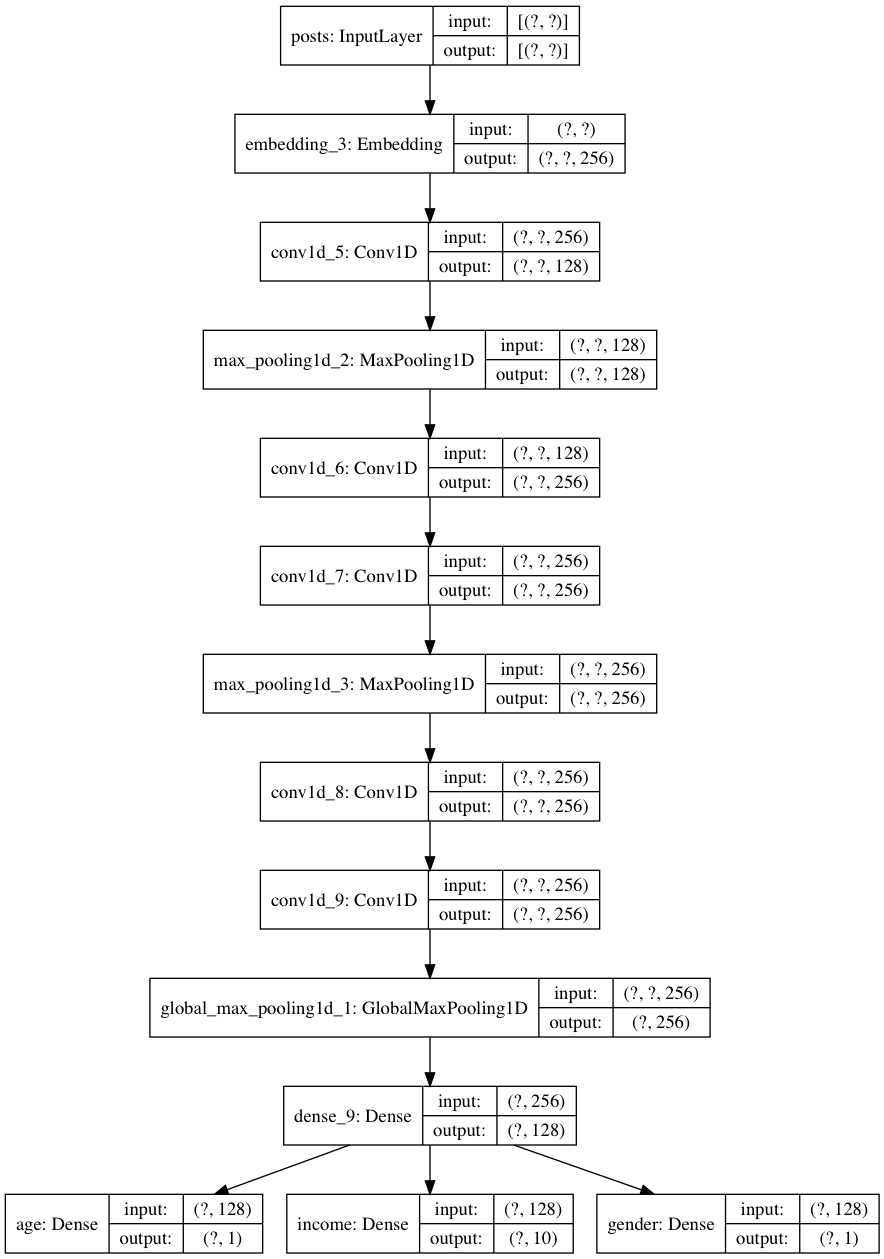

In [40]:
plot_model(model, show_shapes = True)

## 5. Модели как слои

В слои можно заворачивать целые модели.

    у = модель (х)

Если модель имеет несколько входных тензоров и несколько выходных тензоров, ее следует вызывать со списком тензоров:

    y1, y2 = модель ([x1, x2])

Когда вы вызываете экземпляр модели, вы повторно используете вес модели - точно так же, как и при вызове экземпляра слоя. Вызов экземпляра, будь то экземпляр уровня или экземпляра модели, всегда будет повторно использовать существующие изученные представления экземпляра, что интуитивно понятно.

In [42]:
from tensorflow.keras import applications 


nbr_classes = 10

# Возьмем готовую модель Xception
xception_base = applications.Xception(weights=None,include_top=False)

# входная картинка  250 × 250 RGB.
left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

left_features = xception_base(left_input)
right_features = xception_base(right_input)

merged_features = layers.concatenate([left_features, right_features], axis=-1)

predictions = layers.Dense(nbr_classes, activation='softmax')(merged_features)

#  Собираем нашу модельку
model = Model([left_input, right_input], predictions)

AttributeError: 'tuple' object has no attribute 'layer'

In [43]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, None, 128)    163968      embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, None, 128)    0           conv1d_5[0][0]                   
____________________________________________________________________________________________

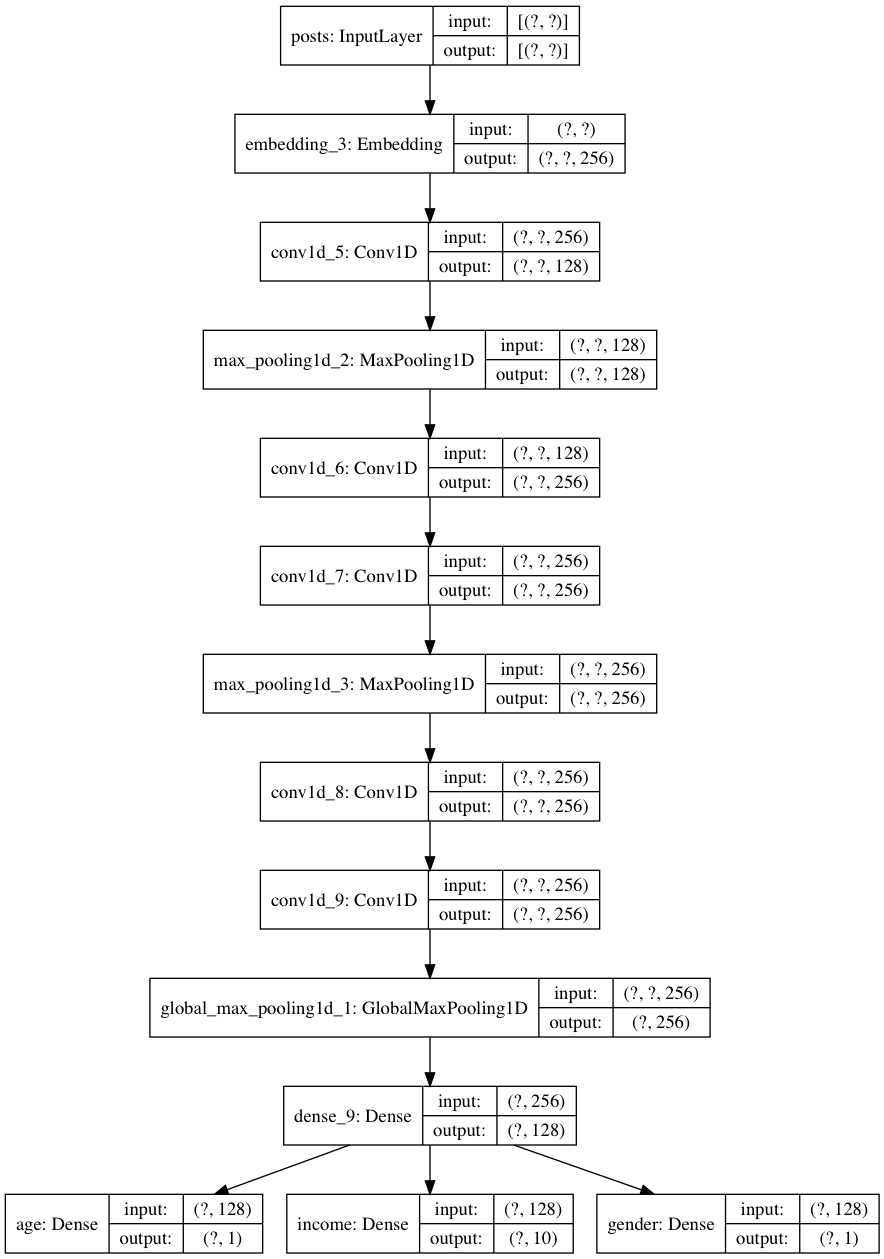

In [44]:
plot_model(model, show_shapes = True)

Итого - давайте теперь соберем модель с двумя входами, где оба входа - обработчики картинок.
Выхода у нас тоже 2 - предположим мы решаем задачу следующего ввида - ищем как контент картинки, так и время года!

#### Ну и на последок 
 мы же все помним, мы можем писать кастомные callback. Теперь поэтапно смотрим на эту прелесть.
 
 Возьмем уже известную вам модельку с прошлой пары и будем модифицировать наши результаты.

In [20]:
import tensorflow as tf
from tensorflow.keras import Sequential
keras, L = tf.keras, tf.keras.layers

import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
y_train = keras.utils.to_categorical(y_train).astype(np.float32)
y_test = keras.utils.to_categorical(y_test).astype(np.float32)

# Отнормировали данные к отрезку [0;1]
X_train = X_train/ 255.
X_test = X_test/ 255.
X_train = np.reshape(X_train,[X_train.shape[0],X_train.shape[1],X_train.shape[2],1])
X_test = np.reshape(X_test,[X_test.shape[0],X_test.shape[1],X_test.shape[2],1])

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$, same padding и $32$ каналами
* ReLU
* Макспулинг размера $2 \times 2$
* Свёртка с ядром $5 \times 5$ и $16$ каналами  и same padding
* ReLU
* Макспулинг размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $60$ нейронами

In [21]:
model_1 = Sequential( )

# model_1.add(L.InputLayer(input_shape=(28,28)))
model_1.add(L.Conv2D(32,(5,5),padding='same',activation='relu',input_shape=(28,28,1)))
model_1.add(L.MaxPool2D((2,2)))
model_1.add(L.Conv2D(16,(5,5),padding='same',activation='relu'))
model_1.add(L.MaxPool2D((2,2),strides=(2,2)))
model_1.add(L.Flatten())
model_1.add(L.Dense(120, activation='relu'))
model_1.add(L.Dense(60, activation='relu'))

model_1.add(L.Dense(10, activation='softmax'))

model_1.compile("adam", "categorical_crossentropy", metrics=["categorical_accuracy"])

hist = model_1.fit(X_train, y_train, validation_split= 0.2,
                        batch_size=500, epochs=3, verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 11s 223us/sample - loss: 0.8316 - categorical_accuracy: 0.7155 - val_loss: 0.4967 - val_categorical_accuracy: 0.8232
Epoch 2/3
48000/48000 [==============================] - 11s 223us/sample - loss: 0.4628 - categorical_accuracy: 0.8327 - val_loss: 0.4226 - val_categorical_accuracy: 0.8477
Epoch 3/3
48000/48000 [==============================] - 12s 246us/sample - loss: 0.4021 - categorical_accuracy: 0.8568 - val_loss: 0.3878 - val_categorical_accuracy: 0.8575


In [55]:
# Наш класс должен быть отнаследован от керасовского класса

class MyCustomCallback(tf.keras.callbacks.Callback):
    pass

# Но мы можем переписать методы, которые мы отнаследовали
# но для начала посмотреть на них

In [56]:
dir(tf.keras.callbacks.Callback)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'set_model',
 'set_params']

In [62]:
# Теперь нам надо переписать методы которые нам потребуются
# А задача в следующем - посмотреть какой класс проседает по точности на валидационных данных
from sklearn.metrics import precision_score

class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,X_val,y_val):
        self.X_val = X_val
        self.y_val = y_val
    def on_epoch_end(self,epoch,logs={}):
        prediction = self.model.predict(self.X_val)
        classes_precision = {}
        for i in range(0,10):
            pred_class = np.argmax(prediction,axis=1)==i
            real_class = np.argmax(self.y_val,axis=1)==i
            classes_precision[i] = precision_score(real_class,pred_class) 
        print(classes_precision)

In [63]:
precision_my = MyCustomCallback(X_test,y_test)

In [65]:
hist = model_1.fit(X_train, y_train, validation_split= 0.2,epochs=1,
                       callbacks=[precision_my])

Train on 48000 samples, validate on 12000 samples
48000/48000 [==============================] - 16s 342us/sample - loss: 0.2525 - categorical_accuracy: 0.9063 - val_loss: 0.3007 - val_categorical_accuracy: 0.8988
